In [1]:
import os
import geopandas as gpd
import subprocess
import re
import numpy as np
import rioxarray as rxr
import rasterio as rio
from rasterio.transform import from_gcps
from rasterio.control import GroundControlPoint
from shapely import geometry
from shapely import affinity
from pyproj import transform, Proj
import leafmap
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from osgeo import gdal, osr; gdal.UseExceptions()
import shutil
from IPython import display
from time import sleep
from scipy.optimize import minimize
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from statistics import stdev

In [2]:
#configure logging to file
import logging
logging.basicConfig(filename='log.txt',level=logging.INFO)
#get handle for logging
logger = logging.getLogger(__name__)
#log start
logger.info('start')

In [3]:
tmp_dir = "tmp"
if os.path.exists(tmp_dir):
    shutil.rmtree(tmp_dir)
os.mkdir(tmp_dir)

geotiff_dir = "data/output/geotiff"
geotiff_cal_dir = "data/output/geotiff_cal"
plot_dir = "data/output/plots"
os.makedirs(geotiff_dir, exist_ok= True)
os.makedirs(geotiff_cal_dir, exist_ok= True)
os.makedirs(tmp_dir, exist_ok= True)
os.makedirs(plot_dir, exist_ok= True)
use_cache = True

In [4]:
assert os.path.exists("data/polygons.geojson"), "data/polygons.geojson does not exist. Please run 1_conversion.ipynb first."
polygons = gpd.read_file("data/polygons.geojson")
print("Detecting intersections...")
inters = []
for id_i, row_i in tqdm(polygons.iterrows()):
    inter = []
    for id_j, row_j in polygons.iterrows():
        if id_i == id_j:
            continue
        if row_i['geometry'].intersects(row_j['geometry']):
            inter.append({"id": id_j,"area": row_i['geometry'].intersection(row_j['geometry']).area})
    inter = sorted(inter, key=lambda k: k['area'], reverse=True)
    inters.append(inter)
polygons['intersect'] = inters

Detecting intersections...


453it [00:15, 29.87it/s]


In [5]:
def calc_hist(src,dst):
    src_min = np.nanmin(src)
    src_max = np.nanmax(src)
    dst_min = np.nanmin(dst)
    dst_max = np.nanmax(dst)
    min_val = min(src_min, dst_min)
    min_val = np.floor(min_val*10)/10
    max_val = max(src_max, dst_max)
    max_val = np.ceil(max_val*10)/10
    bins = np.arange(min_val, max_val, 0.1)
    src_hist = np.histogram(src, bins=bins, range=(min_val, max_val))
    dst_hist = np.histogram(dst, bins=bins, range=(min_val, max_val))
    return src_hist, dst_hist
def loss_function(x, src, dst):
    dst = dst+x
    src_hist, dst_hist = calc_hist(src, dst)
    #calc rmse
    #rmse = np.sqrt(np.mean((src_hist[0]-dst_hist[0])**2))
    mae = np.mean(np.abs(src_hist[0]-dst_hist[0]))
    return mae

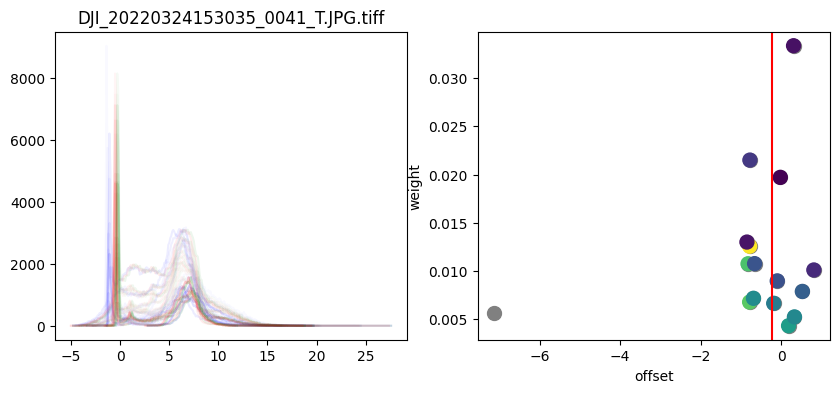

 55%|█████▍    | 247/452 [1:41:44<1:24:26, 24.71s/it]


KeyboardInterrupt: 

In [6]:
polygons['std']=None
polygons['offset']=None
polygons['calibrated']=False

src_id = 141
src = polygons.iloc[src_id]
src_raster = rxr.open_rasterio(f"{geotiff_dir}/{src['name']}", masked=True)
src_raster.rio.to_raster(f"{geotiff_cal_dir}/{src['name']}")
#set src as calibrated
polygons.loc[src_id, 'score'] = 0.0
polygons.loc[src_id, 'offset'] = 0.0
polygons.loc[src_id, 'calibrated'] = True
print("Setting the calibration order...")
id_dists = []
for id_i, row_i in tqdm(polygons.iterrows()):
    src_x, src_y = src['geometry'].centroid.xy
    row_i_x, row_i_y = row_i['geometry'].centroid.xy
    dist = np.sqrt((src_x[0]-row_i_x[0])**2 + (src_y[0]-row_i_y[0])**2)
    id_dists.append({"id": id_i, "dist": dist})
id_dists = sorted(id_dists, key=lambda k: k['dist'])
#remove first element from id_dists
id_dists.pop(0)
print("Calibrating pairs...")
pbar = tqdm(id_dists)
for id_dist in pbar:
    dst_id = id_dist['id']
    dst = polygons.iloc[dst_id]
    dst_raster = rxr.open_rasterio(f"{geotiff_dir}/{dst['name']}", masked=True)
    offsets = []
    areas = []
    losses = []
    src_hists = []
    dst_hists = []

    for inter in polygons.iloc[dst_id]['intersect']:
        if polygons.iloc[inter['id']]['calibrated'] and inter['area'] > 60:
            src_id = inter['id']
            src = polygons.iloc[src_id]
            src_raster = rxr.open_rasterio(f"{geotiff_cal_dir}/{src['name']}", masked=True)#.rio.clip([dst['geometry']])
            src_raster = src_raster.rio.reproject_match(dst_raster)
            inter = src['geometry'].intersection(dst['geometry'])
            src_clip = src_raster.rio.clip([inter])
            dst_clip = dst_raster.rio.clip([inter])
            src_clip = gaussian_filter(src_clip, sigma=1)
            dst_clip = gaussian_filter(dst_clip, sigma=1)
            src_hist, dst_hist = calc_hist(src_clip, dst_clip)
            src_hists.append(src_hist)
            dst_hists.append(dst_hist)
            logger.info(f"Calibrating {src['name']} and {dst['name']}")
            result = minimize(loss_function, x0=0.0, args=(src_clip, dst_clip), tol=1e-3, method='Powell', bounds=[(-10.,10.)])
            if result.success:
                offsets.append(result.x[0])
                areas.append(inter.area)
                losses.append(result.fun)

    offsets = np.array(offsets)
    areas = np.array(areas)
    losses = np.array(losses)
    weights = 1./losses
    offsets_all = offsets.copy()
    weights_all = weights.copy()
    if len(offsets) > 1:
        indices = np.abs(offsets - np.mean(offsets)) < 2*np.std(offsets) #remove outliers
        offsets = offsets[indices]
        weights = weights[indices]
        areas = areas[indices]
    score = weights.mean()
    offset = (offsets*weights).sum()/weights.sum()
    #weights = weights/weights.sum()
    logger.info(f"Score: {score}, Offset: {offset}")
    display.clear_output(wait=True)
    #create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    #plot the histograms
    alphas = weights/weights.sum()
    for src_hist, alpha in zip(src_hists, alphas):
        ax1.plot(src_hist[1][:-1], src_hist[0], color='blue', alpha=alpha)
    for dst_hist, alpha in zip(dst_hists, alphas):
        ax1.plot(dst_hist[1][:-1], dst_hist[0], color='green', alpha=alpha)
        ax1.plot([_+offset for _ in dst_hist[1][:-1]], dst_hist[0], color="red", alpha=alpha)

    #set title
    ax1.set_title(f"{dst['name']}")

    #plot offsets against weights
    ax2.scatter(offsets_all, weights_all, s=100, color='gray')
    ax2.scatter(offsets, weights, s=100, c=areas)
    #ax2.scatter(offsets, weights, s=30, c=areas)

    #show colorbar for ax2
    #set axes labels
    ax2.set_xlabel('offset')
    ax2.set_ylabel('weight')
    #plot offset as a red line
    ax2.axvline(offset, color='r')
    plt.show()
    logger.info("After plotting")

    polygons.loc[dst_id, 'std'] = stdev(offsets) if len(offsets) > 1 else 0.0
    polygons.loc[dst_id, 'offset'] = offset
    polygons.loc[dst_id, 'calibrated'] = True
    
    dst_raster = (dst_raster+offset)
    #replace nan with -9999
    dst_raster = dst_raster.where(~np.isnan(dst_raster), -9999)
    dst_raster = dst_raster.rio.write_nodata(-9999)
    dst_raster.rio.to_raster(f"{geotiff_cal_dir}/{dst['name']}")
    polygons.loc[dst_id, 'calibrated'] = True
    logger.info("After writing raster")

In [ ]:
#convert interects to string
#polygons['intersect'] = polygons['intersect'].apply(lambda x: str(x))
polygons.to_file("data/calibration.geojson", driver="GeoJSON")